In [4]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd      # Data manipulation and analysis
import numpy as np       # Numerical computing
import requests          # Making HTTP requests to download data
import seaborn as sns    # Advanced data visualization
import matplotlib.pyplot as plt  # Basic data visualization

# Import machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.feature_extraction.text import TfidfVectorizer  # Converting text to numerical features
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score  # Model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # Machine learning algorithm
from sklearn.utils import resample  # Tool for resampling data

# # Suppress warning messages to keep the output clean
# import warnings
# warnings.filterwarnings('ignore')


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3906
           1       0.97      0.96      0.97      3906

    accuracy                           0.97      7812
   macro avg       0.97      0.97      0.97      7812
weighted avg       0.97      0.97      0.97      7812



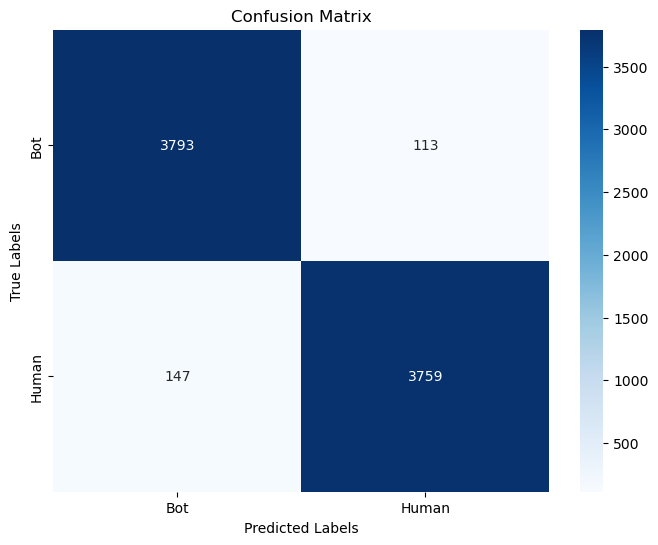

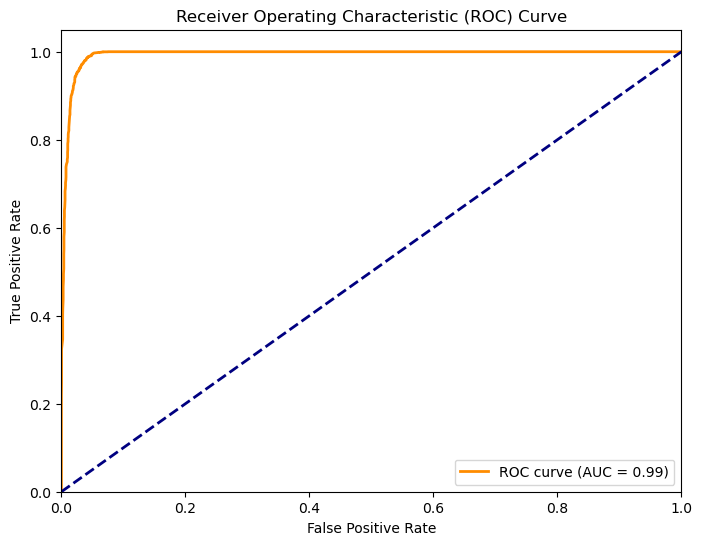

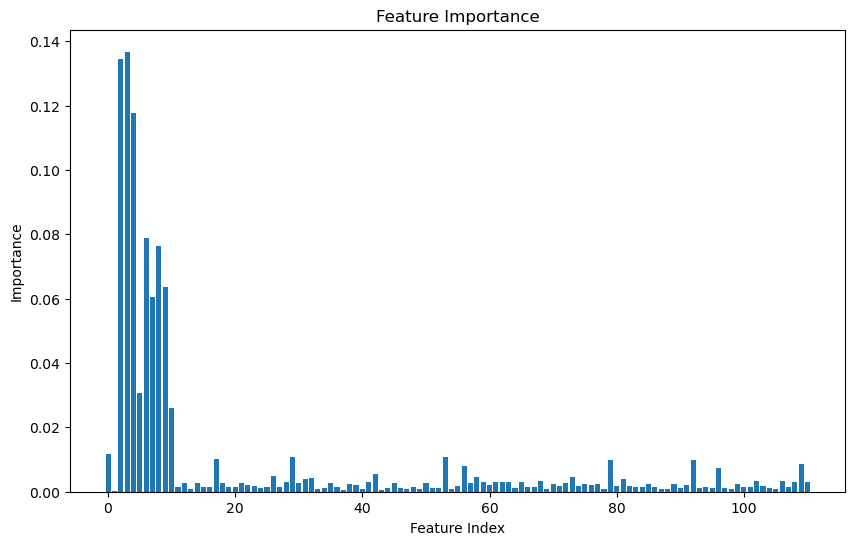

In [ ]:

def load_dataset():
    url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
    response = requests.get(url)
    

    with open("twitter_human_bots_dataset.csv", "wb") as f:
        f.write(response.content)
    
    df = pd.read_csv("twitter_human_bots_dataset.csv")
    
    return df

# Function to preprocess the raw data
def preprocess_data(df):
    # Remove any rows with missing values to ensure data quality
    df = df.dropna().reset_index(drop=True)
    
    # Convert categorical 'account_type' to numerical values
    # This transforms 'bot' and 'human' into 0 and 1
    le = LabelEncoder()
    df['account_type_encoded'] = le.fit_transform(df['account_type'])
    
    # Convert boolean columns to integers (0 or 1)
    # This makes boolean features usable by the machine learning model
    boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
    for col in boolean_cols:
        df[col] = df[col].astype(int)
    
    # Encode language as a numerical feature
    df['lang_encoded'] = le.fit_transform(df['lang'])
    
    # Remove unnecessary columns that won't help in prediction
    df_model = df.drop(columns=[
        'Unnamed: 0', 'created_at', 'id',
        'profile_background_image_url', 'profile_image_url',
        'screen_name', 'location', 'account_type', 'lang'
    ])
    
    # Convert text descriptions to numerical features using TF-IDF
    # TF-IDF helps capture the importance of words in the description
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    X_description_tfidf = tfidf_vectorizer.fit_transform(df['description'])
    X_description_tfidf = X_description_tfidf.toarray()
    
    # Select numerical features
    X_numerical = df_model.drop(columns=['account_type_encoded', 'description'], axis=1)
    
    # Combine numerical features with text features
    X_combined = np.hstack((X_numerical.to_numpy(), X_description_tfidf))
    
    # Get the target variable (bot or human)
    y = df_model['account_type_encoded']
    
    return X_combined, y

# Function to balance the dataset
def balance_data(X, y):
    # Create a DataFrame that includes both features and target
    df_combined = pd.DataFrame(X)
    df_combined['account_type_encoded'] = y
    
    # Separate human and bot accounts
    df_majority = df_combined[df_combined['account_type_encoded'] == 1]  # Humans
    df_minority = df_combined[df_combined['account_type_encoded'] == 0]  # Bots
    
    # Oversample the minority class (bots)
    # This helps prevent the model from being biased towards the majority class
    df_minority_oversampled = resample(df_minority,
                                        replace=True,  # Sample with replacement
                                        n_samples=len(df_majority),  # Match majority class size
                                        random_state=42)  # Ensure reproducibility
    
    # Combine the majority class with the oversampled minority class
    df_balanced = pd.concat([df_majority, df_minority_oversampled])
    
    # Separate features and target again
    X_balanced = df_balanced.drop('account_type_encoded', axis=1).to_numpy()
    y_balanced = df_balanced['account_type_encoded']
    
    return X_balanced, y_balanced

# Function to create a confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap visualization of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Bot", "Human"], 
                yticklabels=["Bot", "Human"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Function to create a Receiver Operating Characteristic (ROC) curve
def plot_roc_curve(y_true, y_proba):
    # Calculate false positive and true positive rates
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    
    # Calculate the Area Under the Curve (AUC)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Main function to run the entire machine learning pipeline
def main():
    # Step 1: Load the dataset
    df = load_dataset()
    
    # Step 2: Preprocess the data (convert to numerical features)
    X, y = preprocess_data(df)
    
    # Step 3: Balance the dataset to handle class imbalance
    X_balanced, y_balanced = balance_data(X, y)
    
    # Step 4: Standardize features (scale to similar ranges)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_balanced)
    
    # Step 5: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
    )
    
    # Step 6: Create a Random Forest Classifier with optimal parameters
    rf = RandomForestClassifier(
        n_estimators=300,  # Number of trees in the forest
        min_samples_split=2,  # Minimum samples required to split an internal node
        min_samples_leaf=1,  # Minimum samples required to be at a leaf node
        max_depth=None,  # No limit on tree depth
        class_weight=None,  # No special weighting for classes
        bootstrap=False,  # No bootstrapping of samples
        random_state=42  # Ensure reproducibility
    )
    
    # Step 7: Train the model
    rf.fit(X_train, y_train)
    
    # Step 8: Make predictions
    y_pred = rf.predict(X_test)  # Predicted labels
    y_proba = rf.predict_proba(X_test)[:, 1]  # Predicted probabilities
    
    # Step 9: Evaluate the model's performance
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Step 10: Visualize results
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_proba)
    
    # Step 11: Visualize feature importance
    feature_importance = rf.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.show()
    
    return rf

# Run the main function if the script is executed directly
if __name__ == '__main__':
    model = main()